# Potencial eletrostático em um capacitor de placas paralelas finitas #

Este código tem como objetivo apresentar o perfil de potencial eletrostático de um capacitor de placas paralelas finitas quando estas são submetidas a uma diferença de potêncial (tensão) $V_0$. Obtido via resolução numérica da equação de Laplace:

$$\nabla^2 V = 0$$

Além disso, o perfil de campo será analisado no plano $xy$, desprezando variações em $z$.

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

# Operadores de diferenciação usados para resolução numérica de EDP's lineares de duas variáveis:

def Dx2(N, h):
    N2 = N**2
    D = sp.eye(N2,k=-1) - 2*sp.eye(N2) + sp.eye(N2,k=1)
    D = D.tolil()
    for i in range(N-1,N2-N, N):
        D[i+1,i] = 0
        D[i,i+1] = 0
    D = D.tocsr()
    D = D / (h**2)
    return D

def Dy2(N, h):
    N2 = N**2
    D = sp.eye(N2, k = - N) - 2*sp.eye(N2) + sp.eye(N2, k = N)
    D = D / (h**2)
    return D

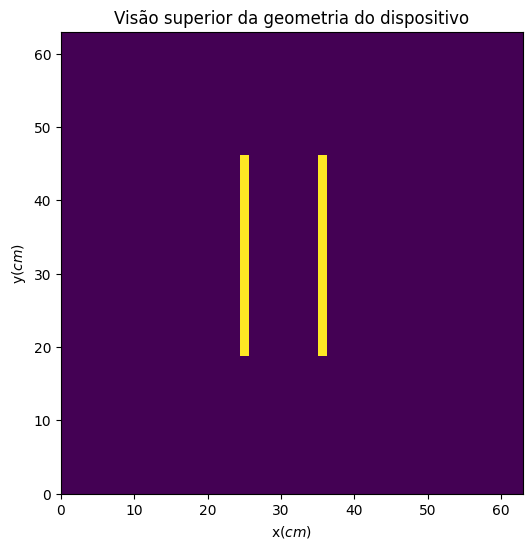

In [2]:
# Dimensões da placa:

L_placa = 1.5 # Largura da placa em cm
H_placa = 28 # Comprimento da placa em cm
d_placas = int(input('Distância entre as placas em cm: '))

# Dimensões da malha de cáculo:

L_malha = 2.25*H_placa
H_malha = 2.25*H_placa

# Construindo o operador linear:

N = 101 # Números de pontos usados na discretização de cada eixo (Pontos formados na malha: N**2)

dx = L_malha / (N-1) # Passo dado em cada eixo
dy = H_malha / (N-1)

Dx = Dx2(N, dx)
Dy = Dy2(N, dy)

Lp = Dx + Dy

# Construindo e preenchendo a matriz dos coeficientes

B = np.zeros((N,N))

ix1 = int((L_malha - d_placas - 2*L_placa)/(2*dx)) 
ix1_fim = int(ix1 + L_placa/dx)
ix2 = int(ix1_fim + d_placas/dx)
ix2_fim = int(ix2 + L_placa/dx)

iy = int((H_malha - H_placa)/(2*dy))
iy_fim = int(iy + H_placa/dy)

B[ix1:ix1_fim, iy:iy_fim] = 1
B[ix2:ix2_fim, iy:iy_fim] = 1

# Visualizando a estrutura:

fig = plt.figure(figsize = (6,6))
plt.imshow(B.T, aspect = 'equal', extent=[0, L_malha, 0, H_malha])
plt.title("Visão superior da geometria do dispositivo")
plt.xlabel(r'x($cm$)')
plt.ylabel(r'y($cm$)')
plt.show()

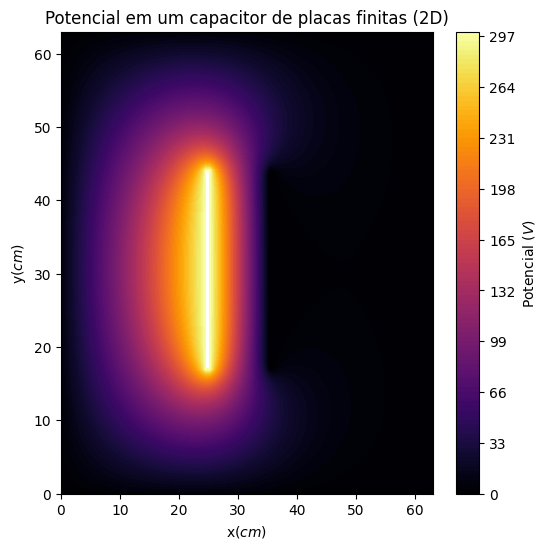

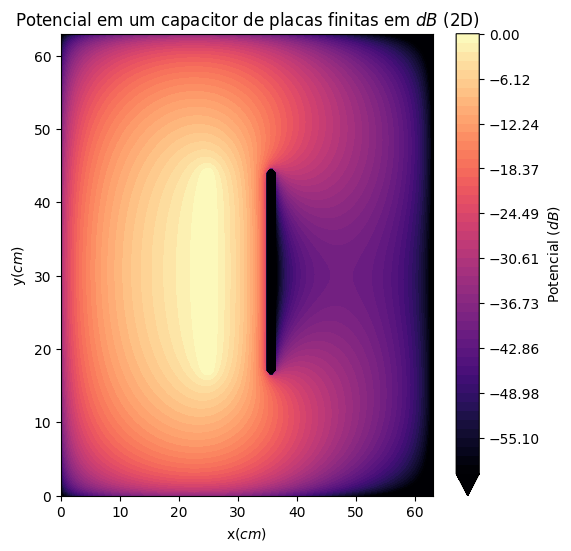

In [3]:
# Montando as equações:

while True:
        T = input("Qual placa esta aterrada? 1 para a da esquerda e 2 para a da direita: ")
        if((T == '1') or (T == '2')):
            break
        else:
            print("Opção inválida! Selecione 1 ou 2")

V0 = np.abs(float(input("Informe a tensão entre as placas em Volts: "))) # abs para evitar problemas com valores negativos.

if(T == '2'):
    B[ix1:ix1_fim, iy:iy_fim] = V0 + 1e-10
    B[ix2:ix2_fim, iy:iy_fim] = 1e-10
else: 
    B[ix1:ix1_fim, iy:iy_fim] = 1e-10
    B[ix2:ix2_fim, iy:iy_fim] = V0 + 1e-10

B = B.ravel() # Tranformando o array bidimensional em um unidimensional

#Ajustando o operador linear:

Lp = Lp.tolil()

for i in range(ix1,ix1_fim,1):
    Lp[N*i+iy:N*i+iy_fim,:] = 0
    for j in range(iy,iy_fim,1):
        Lp[N*i+j,N*i+j] = 1
for i in range(ix2,ix2_fim,1):
    Lp[N*i+iy:N*i+iy_fim, :] = 0
    for j in range(iy,iy_fim,1):
        Lp[N*i+j,N*i+j] = 1

Lp = Lp.tocsr()

V = sp.linalg.spsolve(Lp, B) # Resolução da equação

V = V.reshape(N,N)

x = np.linspace(0,L_malha, N)
y = np.linspace(0,H_malha, N)

X, Y = np.meshgrid(y,x)

fig = plt.figure(figsize = (6,6))
count = plt.contourf(Y, X, V, levels = 100, cmap = "inferno")
plt.colorbar(count, label = r'Potencial ($V$)')
plt.xlabel(r'x($cm$)')
plt.ylabel(r'y($cm$)')
plt.title(r'Potencial em um capacitor de placas finitas (2D)')
plt.show()

# Potencial do capacitor em dB:

V_dB = 20*np.log10(V/np.max(V))

levels_dB = np.linspace(-60,0,50) # 50 linhas equipotenciais, indo de -60 até 0 dB
fig = plt.figure(figsize=(6,6))
count_dB = plt.contourf(Y,X, V_dB, levels = levels_dB, cmap = 'magma', extend = 'min')
plt.colorbar(count_dB, label = r'Potencial ($dB$)')
plt.xlabel(r'x($cm$)')
plt.ylabel(r'y($cm$)')
plt.title(r'Potencial em um capacitor de placas finitas em $dB$ (2D)')
plt.show()